In [258]:
%pip install pandas
%pip install scikit-learn
%pip install nltk

import pandas as pd

read = pd.read_csv('/Users/littl/Documents/ASA-DataFest/Data/responses_full.csv')

df = pd.DataFrame(read)
df.drop(columns=['lrn_option_0', 'lrn_option_1', 'lrn_option_2', 'lrn_option_3', 'lrn_option_4',
       'lrn_option_5', 'lrn_option_6', 'lrn_option_7', 'lrn_option_8',
       'lrn_option_9', 'lrn_option_10', 'lrn_option_11', 'chapter_number', 'section_number', 'points_earned', 'points_possible', 'dt_submitted', 'completes_page', 'user_agent', 'lrn_response_id', 'lrn_activity_reference', 'lrn_question_reference',
       'lrn_question_position', 'lrn_type', 'lrn_dt_started', 'lrn_dt_saved',
       'lrn_status', 'attempt'], inplace=True)



You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/var/folders/zv/b1gy51ms7yv5bf2qm_gz0_fw0000gn/T/ipykernel_40746/659146205.py:7: DtypeWarning: Columns (32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  read = pd.read_csv('/Users/littl/Documents/ASA-DataFest/Data/responses_full.csv')


In [259]:
# unique_institutions = df['institution_id'].unique()
# for inst in unique_institutions:
#     print("Number of items with institution_id ", inst, ": ", len(df[df["institution_id"] == inst]))

In [260]:
# unique_names = {}
# counter_inst = 1
# counter_stud = 1
# counter_class = 1

# # Iterate over each row in the 'Institution' column
# for index, row in df.iterrows():
#     institution = row['institution_id']
#     student = row['student_id']
#     class_id = row['class_id']
    
#     # Check if the institution has been encountered before
#     if institution not in unique_names:
#         # If not encountered before, assign a new unique name
#         unique_names[institution] = f'Institute {counter_inst}'
#         counter_inst += 1

#     if student not in unique_names:
#         # If not encountered before, assign a new unique name
#         unique_names[student] = f'Student {counter_stud}'
#         counter_stud += 1
        
#     if class_id not in unique_names:
#         # If not encountered before, assign a new unique name
#         unique_names[class_id] = f'Class {counter_class}'
#         counter_class += 1
    
    
    
#     # Rename the institution in the DataFrame
#     df.at[index, 'institution_id'] = unique_names[institution]
#     df.at[index, 'student_id'] = unique_names[student]
#     df.at[index, 'class_id'] = unique_names[class_id]




In [261]:
# CLEANING DATA

filtered_df = df[~df['book'].str.contains('High School / Advanced Statistics and Data Science I \(ABC\)')]

filtered_df = filtered_df[filtered_df['page'] == 'End of Course Survey (Required)']
filtered_df.dropna(subset=['prompt', 'response'], inplace=True)
filtered_df.reset_index(drop=True, inplace=True)
end_course_survey_subset = filtered_df[['prompt', 'response', 'student_id']]
# end_course_survey_subset['prompt'] = end_course_survey_subset['prompt'].str.replace('"', '')
# for i in end_course_survey_subset['prompt'].unique():
#     print('-------------------')
#     print(i)
end_course_survey_subset = end_course_survey_subset[~end_course_survey_subset['prompt'].str.contains('To what extent do the following behaviors, thoughts, and feelings describe you in this course in the last three weeks or so?')]
end_course_survey_subset = end_course_survey_subset[~end_course_survey_subset['prompt'].str.contains("Please rate your level of agreement (or disagreement) with each of the following statements, regarding your experience in the course for the past three weeks or so.", regex=False)]
end_course_survey_subset = end_course_survey_subset[~end_course_survey_subset['response'].str.contains('null')]
end_course_survey_subset.reset_index(drop=True, inplace=True)

target_prompt = "<strong>Please rate your level of agreement (or disagreement) with each of the following statements.</strong>"


questions = [
    "I am confident I can learn the material in this class.",
    "I expect to do well in this class.",
    "What I'm learning in this class will be useful in the future.",
    "What we learn in this class is relevant to my everyday life.",
    "I think this class is interesting.",
    "I like this class.",
    "I have to give up too much to do well in this class.",
    "This class is too stressful for me.",
    "In this class, you used R to analyze data. How do you feel about this now?"
]
question_map_agreement_scale = {
    '0': "Strongly Disagree",
    '1':"Disagree",
    '2': "Slightly Disagree",
    '3':"Slightly Agree",
    '4': "Agree",
    '5': "Strongly Agree"
}

new_rows = []

for index, row in end_course_survey_subset.iterrows():
    if row['prompt'] == target_prompt:
        responses = row['response']
        
        numbers = [responses[2 + 5 * i] for i in range(0, 9)]
     

        for i in range(0, 9):
            
            number = question_map_agreement_scale[numbers[i]]
            new_rows.append({'prompt': questions[i], 'response': number})

        
    
end_course_survey_subset = end_course_survey_subset.drop(index=end_course_survey_subset[end_course_survey_subset['prompt'] == target_prompt].index)
end_course_survey_subset = pd.concat([end_course_survey_subset, pd.DataFrame(new_rows)], ignore_index=True)


# end_course_survey_subset = end_course_survey_subset[~end_course_survey_subset['prompt'].str.contains('Please rate your level of agreement (or disagreement) with each of the following statements, regarding your experience in the course for the past three weeks or so.')]

for index, row in end_course_survey_subset.iterrows():
    if row['prompt'] == 'In this class, you used R to analyze data. How do you feel about this now?':
        if row['response'] == 'Strongly Disagree':
            end_course_survey_subset.at[index, 'response'] = 'Strongly negative'
        elif row['response'] == 'Disagree':
            end_course_survey_subset.at[index, 'response'] = 'Negative'
        elif row['response'] == 'Slightly Disagree':
            end_course_survey_subset.at[index, 'response'] = 'Somewhat negative'
        elif row['response'] == 'Slightly Agree':
            end_course_survey_subset.at[index, 'response'] = 'Somewhat positive'
        elif row['response'] == 'Agree':
            end_course_survey_subset.at[index, 'response'] = 'Positive'
        elif row['response'] == 'Strongly Agree':
            end_course_survey_subset.at[index, 'response'] = 'Strongly positive'

end_course_survey_subset.to_csv('/Users/littl/Documents/ASA-DataFest/Data/end_course_survey_subset.csv', index=False)
# end_course_survey_subset['prompt'].unique()

In [262]:
# import nltk
# nltk.download('stopwords')
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize



# # Assuming 'end_course_survey_subset' is your DataFrame containing questions and responses

# # Preprocessing
# stop_words = set(stopwords.words('english'))

# def preprocess_text(text):
#     words = word_tokenize(text)
#     words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]
#     return ' '.join(words)

# end_course_survey_subset['Processed_Response'] = end_course_survey_subset['response'].apply(preprocess_text)

# # Vectorization
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(end_course_survey_subset['Processed_Response'])

# # Semantic Analysis (Clustering)
# num_clusters = 5  # Adjust this based on your data
# kmeans = KMeans(n_clusters=num_clusters)
# kmeans.fit(tfidf_matrix)
# end_course_survey_subset['Cluster'] = kmeans.labels_

# # Interpretation and Actionable Insights
# clusters = end_course_survey_subset.groupby('Cluster')
# for cluster_id, cluster_data in clusters:
#     print(f"Cluster {cluster_id}:")
#     print(cluster_data[['prompt', 'response']])
#     print("="*50)

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


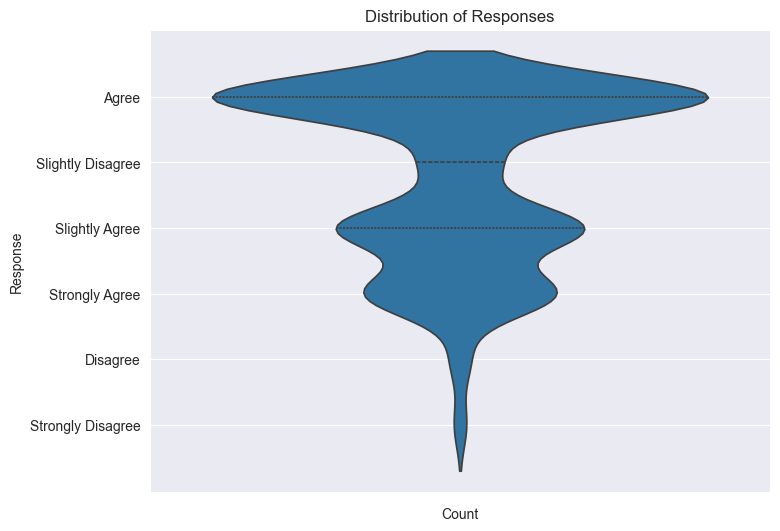

In [263]:
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

confident_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'I am confident I can learn the material in this class.']

plt.figure(figsize=(8, 6))
sns.violinplot(y='response', data=confident_df, inner='quartile')
plt.title('Distribution of Responses')
plt.xlabel('Count')
plt.ylabel('Response')
plt.show()


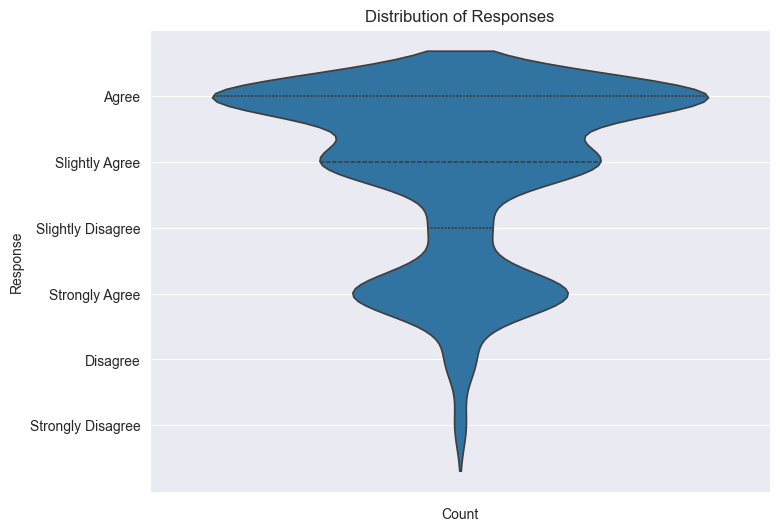

In [264]:
expect_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'I expect to do well in this class.']


plt.figure(figsize=(8, 6))
sns.violinplot(y='response', data=expect_df, inner='quartile')
plt.title('Distribution of Responses')
plt.xlabel('Count')
plt.ylabel('Response')
plt.show()


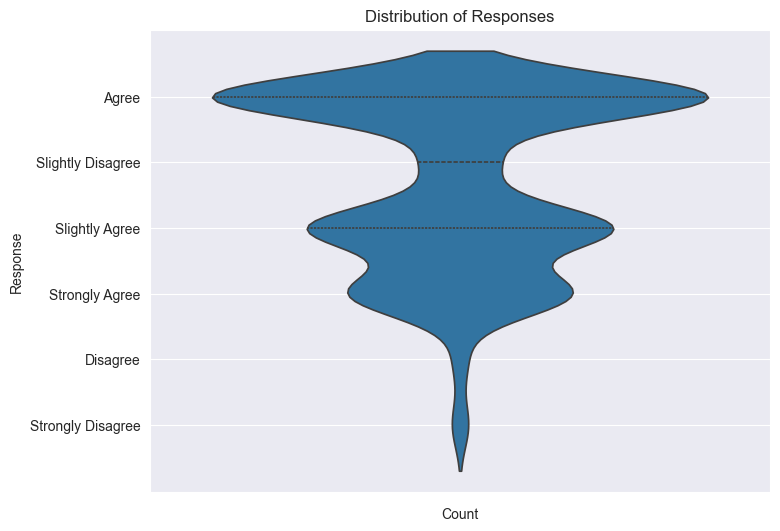

In [265]:
learn_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'What I\'m learning in this class will be useful in the future.']

plt.figure(figsize=(8, 6))
sns.violinplot(y='response', data=learn_df, inner='quartile')
plt.title('Distribution of Responses')
plt.xlabel('Count')
plt.ylabel('Response')
plt.show()

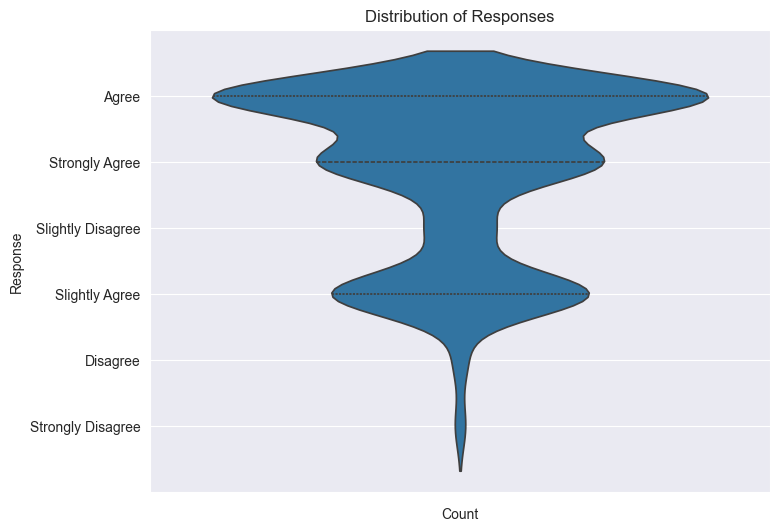

In [266]:
relevant_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'What we learn in this class is relevant to my everyday life.']

plt.figure(figsize=(8, 6))
sns.violinplot(y='response', data=relevant_df, inner='quartile')
plt.title('Distribution of Responses')
plt.xlabel('Count')
plt.ylabel('Response')
plt.show()

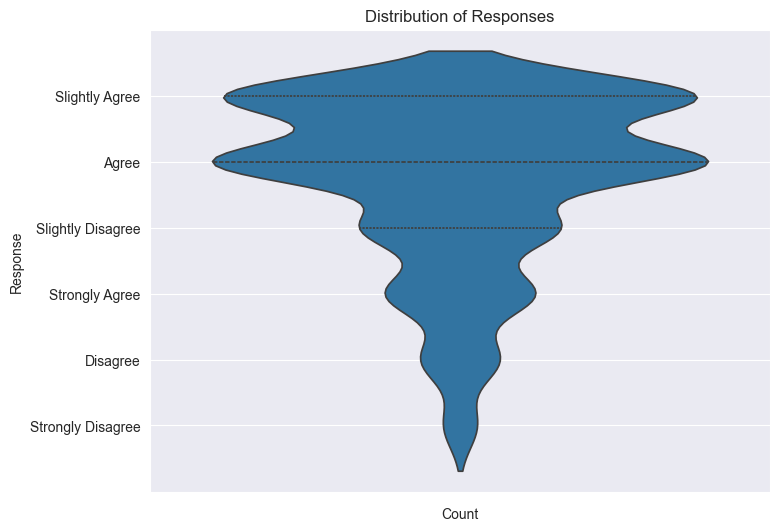

In [267]:
interedting_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'I think this class is interesting.']

plt.figure(figsize=(8, 6))
sns.violinplot(y='response', data=interedting_df, inner='quartile')
plt.title('Distribution of Responses')
plt.xlabel('Count')
plt.ylabel('Response')
plt.show()

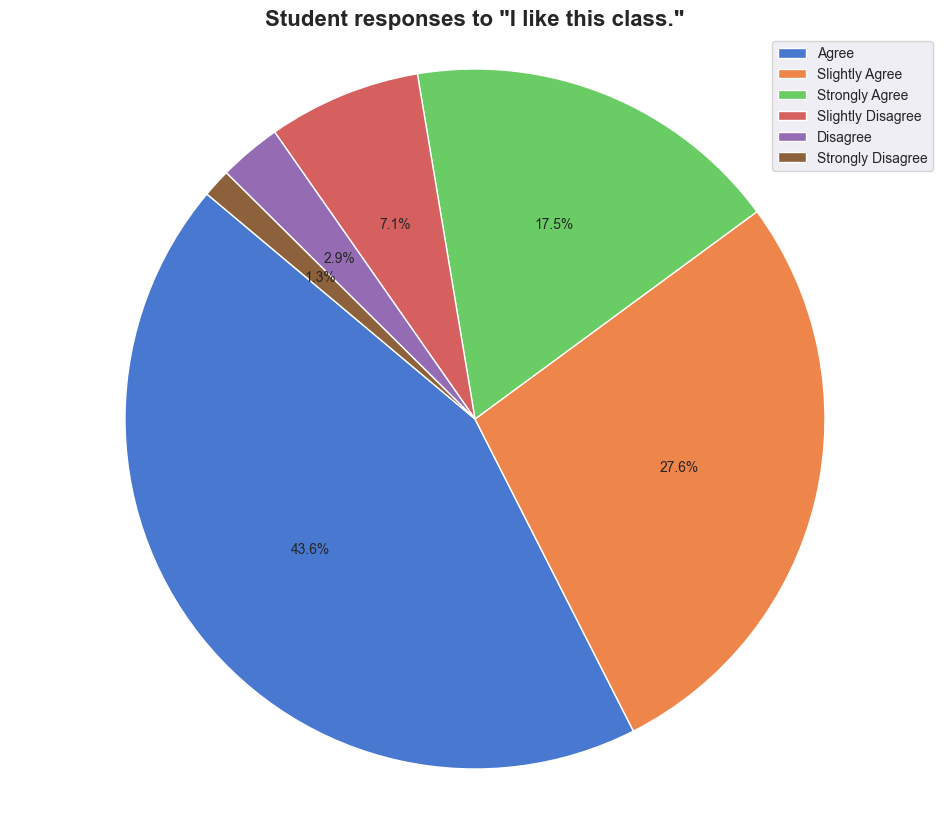

In [281]:

import matplotlib.pyplot as plt
import seaborn as sns

like_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'I like this class.']

# Count occurrences of each response category
response_counts = like_df['response'].value_counts()

# Plotting a pie chart with Seaborn styling
plt.figure(figsize=(12, 10))
patches, texts, _ = plt.pie(response_counts, startangle=140, autopct='%1.1f%%', wedgeprops=dict(width=1), colors=sns.color_palette("muted", len(response_counts)))
plt.legend(patches, response_counts.index, loc="best")
plt.title('Student responses to "I like this class."', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

/var/folders/zv/b1gy51ms7yv5bf2qm_gz0_fw0000gn/T/ipykernel_40746/3841529657.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y='response', data=time_df, inner='quartile', palette=purple_palette)


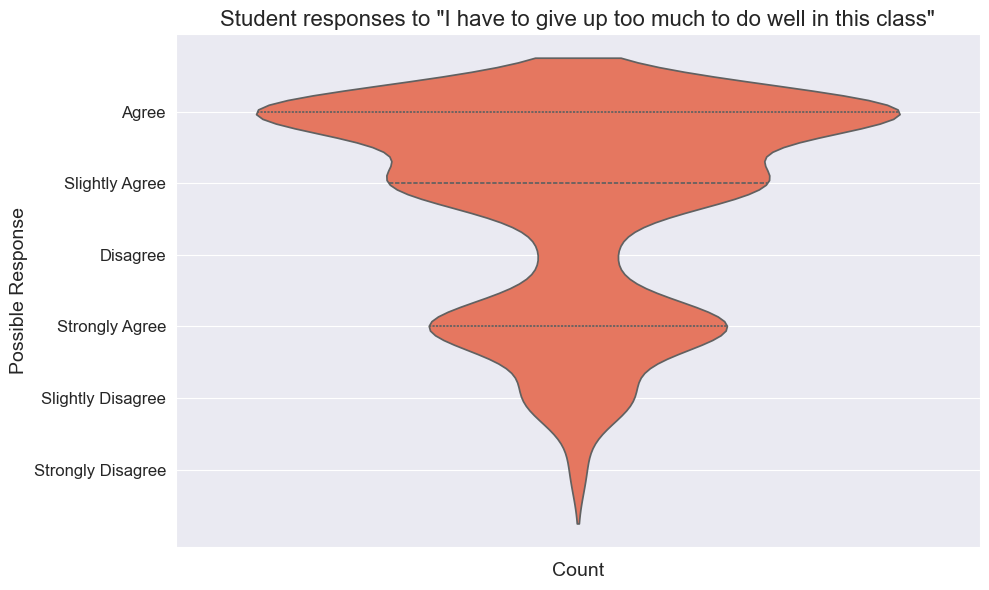

In [269]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom color palette with shades of purple
sns.set_style('darkgrid')
purple_palette = sns.color_palette("Reds", 1)

# Filter DataFrame for the specific prompt
time_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'I have to give up too much to do well in this class.']

# Plotting the violin plot with customizations
plt.figure(figsize=(10, 6))
sns.violinplot(y='response', data=time_df, inner='quartile', palette=purple_palette)
plt.title('Student responses to "I have to give up too much to do well in this class"', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Possible Response', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



/var/folders/zv/b1gy51ms7yv5bf2qm_gz0_fw0000gn/T/ipykernel_40746/619770006.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_counts.values, y=response_counts.index, palette=purple_palette)
/var/folders/zv/b1gy51ms7yv5bf2qm_gz0_fw0000gn/T/ipykernel_40746/619770006.py:16: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=response_counts.values, y=response_counts.index, palette=purple_palette)


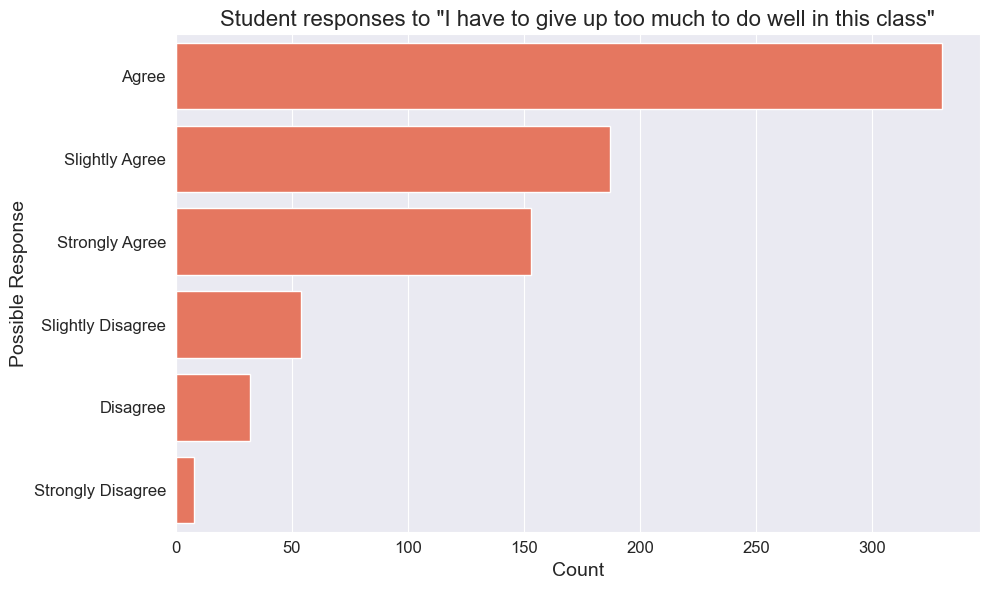

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom color palette with shades of purple
sns.set_style('darkgrid')
purple_palette = sns.color_palette("Reds", 1)

# Filter DataFrame for the specific prompt
time_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'I have to give up too much to do well in this class.']

# Count the occurrences of each response category
response_counts = time_df['response'].value_counts()

# Plotting the horizontal bar plot with customizations
plt.figure(figsize=(10, 6))
sns.barplot(x=response_counts.values, y=response_counts.index, palette=purple_palette)
plt.title('Student responses to "I have to give up too much to do well in this class"', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Possible Response', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


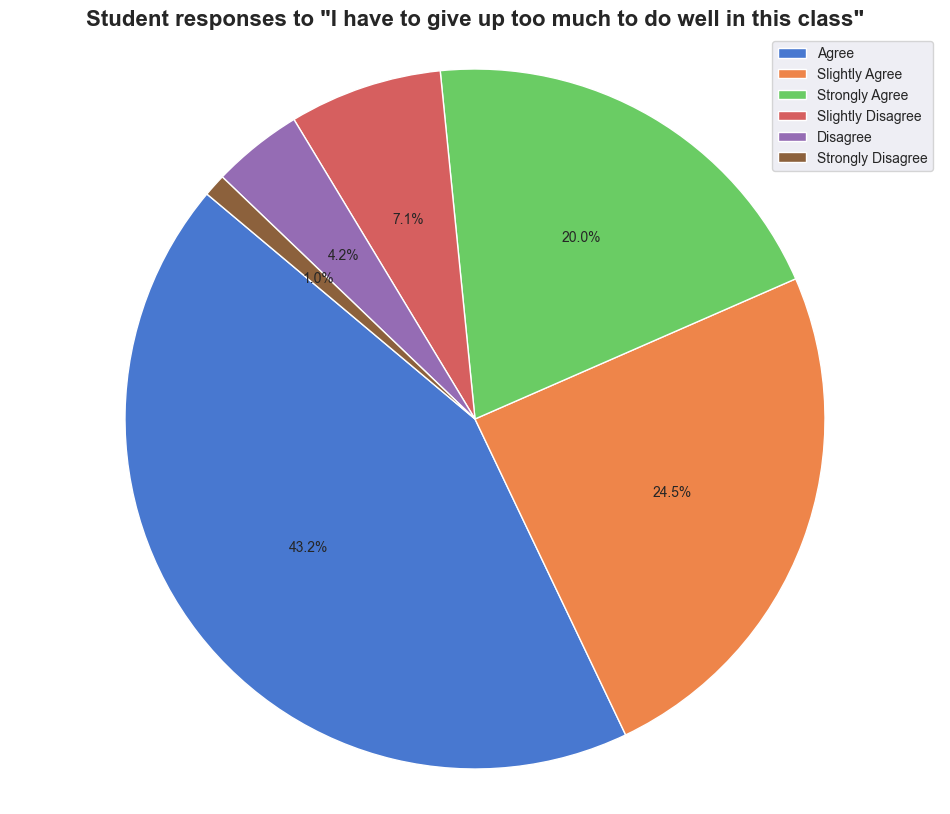

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter DataFrame for the specific prompt
time_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'I have to give up too much to do well in this class.']

# Count occurrences of each response category
response_counts = time_df['response'].value_counts()

# Plotting a pie chart with Seaborn styling
plt.figure(figsize=(12, 10))
patches, texts, _ = plt.pie(response_counts, startangle=140, autopct='%1.1f%%', wedgeprops=dict(width=1), colors=sns.color_palette("muted", len(response_counts)))
plt.legend(patches, response_counts.index, loc="best")
plt.title('Student responses to "I have to give up too much to do well in this class"', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()





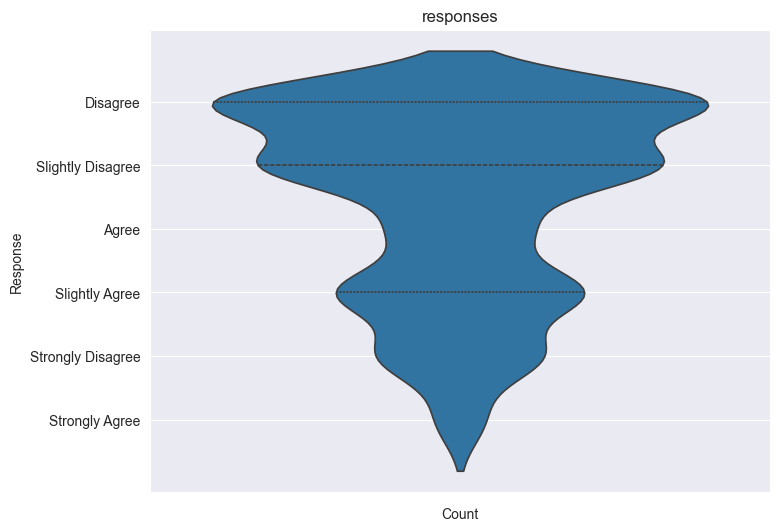

In [272]:
stress_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'This class is too stressful for me.']

plt.figure(figsize=(8, 6))
sns.violinplot(y='response', data=stress_df, inner='quartile')
plt.title('responses')
plt.xlabel('Count')
plt.ylabel('Response')
plt.show()


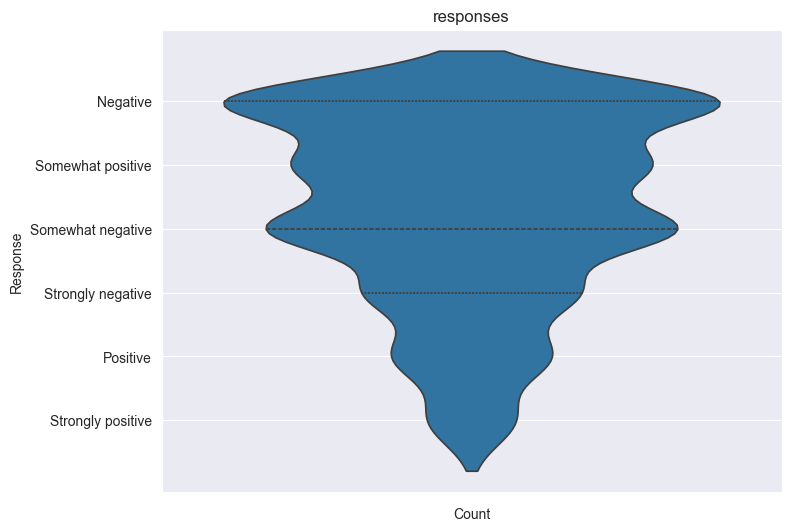

In [273]:
analyze_r_df = end_course_survey_subset[end_course_survey_subset['prompt'] == 'In this class, you used R to analyze data. How do you feel about this now?']

plt.figure(figsize=(8, 6))
sns.violinplot(y='response', data=analyze_r_df, inner='quartile')
plt.title('responses')
plt.xlabel('Count')
plt.ylabel('Response')
plt.show()

In [274]:
prompts = ['What advice would you give to future students who want to do well in this course?',
           'What, if anything, made it hard to succeed in this class?']

semantic_df = end_course_survey_subset[end_course_survey_subset['prompt'].isin(prompts)]
semantic_df.to_csv('/Users/littl/Documents/ASA-DataFest/Data/semantic_questions.csv', index=False)

In [275]:
import pandas as pd

# Load the CSV file to understand its structure
file_path = '/Users/littl/Documents/ASA-DataFest/Data/semantic_questions.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure and content
data.head()

from collections import Counter
import re

# Function to clean and preprocess text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Separate responses based on the questions
advice_responses = data[data['prompt'].str.contains("What advice would you give")]['response'].apply(clean_text)
challenges_responses = data[data['prompt'].str.contains("What, if anything, made it hard")]['response'].apply(clean_text)

# Tokenize the responses and count word frequency
advice_words = Counter(" ".join(advice_responses).split())
challenges_words = Counter(" ".join(challenges_responses).split())

# Get the most common words and their counts for both sets of responses
most_common_advice = advice_words.most_common(15)
most_common_challenges = challenges_words.most_common(15)

(most_common_advice, most_common_challenges)

from sklearn.feature_extraction.text import CountVectorizer

# Function to get most common n-grams
def get_top_ngrams(corpus, n=None, ngrams=(1,3), top=15):
    vec = CountVectorizer(ngram_range=ngrams, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top]

# Get the top 10 bi-grams and tri-grams for advice and challenges responses
top_advice_ngrams = get_top_ngrams(advice_responses, ngrams=(2,3), top=15)
top_challenges_ngrams = get_top_ngrams(challenges_responses, ngrams=(2,3), top=15)

(top_advice_ngrams, top_challenges_ngrams)



([('make sure', 113),
  ('read textbook', 46),
  ('pay attention', 46),
  ('ask questions', 33),
  ('understand concepts', 32),
  ('sure understand', 27),
  ('make sure understand', 26),
  ('future students', 22),
  ('office hours', 22),
  ('read book', 19),
  ('time understand', 16),
  ('understand material', 16),
  ('read chapters', 14),
  ('ask help', 14),
  ('try understand', 13)],
 [('hard succeed', 50),
  ('succeed class', 48),
  ('hard succeed class', 31),
  ('feel like', 18),
  ('felt like', 17),
  ('hard understand', 13),
  ('difficult succeed', 12),
  ('class hard', 10),
  ('time commitment', 9),
  ('time management', 8),
  ('class difficult', 8),
  ('dont think', 8),
  ('think hard', 8),
  ('fast paced', 8),
  ('class really', 7)])

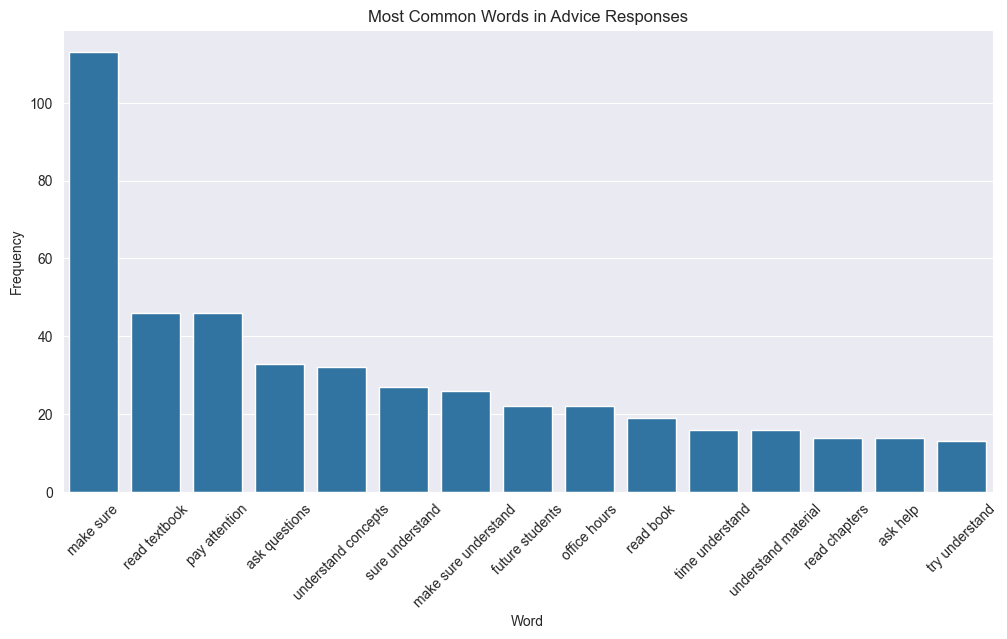

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in top_advice_ngrams], y=[word[1] for word in top_advice_ngrams])
plt.title('Most Common Words in Advice Responses')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

/var/folders/zv/b1gy51ms7yv5bf2qm_gz0_fw0000gn/T/ipykernel_40746/4067166383.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[0] for word in top_advice_ngrams], y=[word[1] for word in top_advice_ngrams], palette=colors)


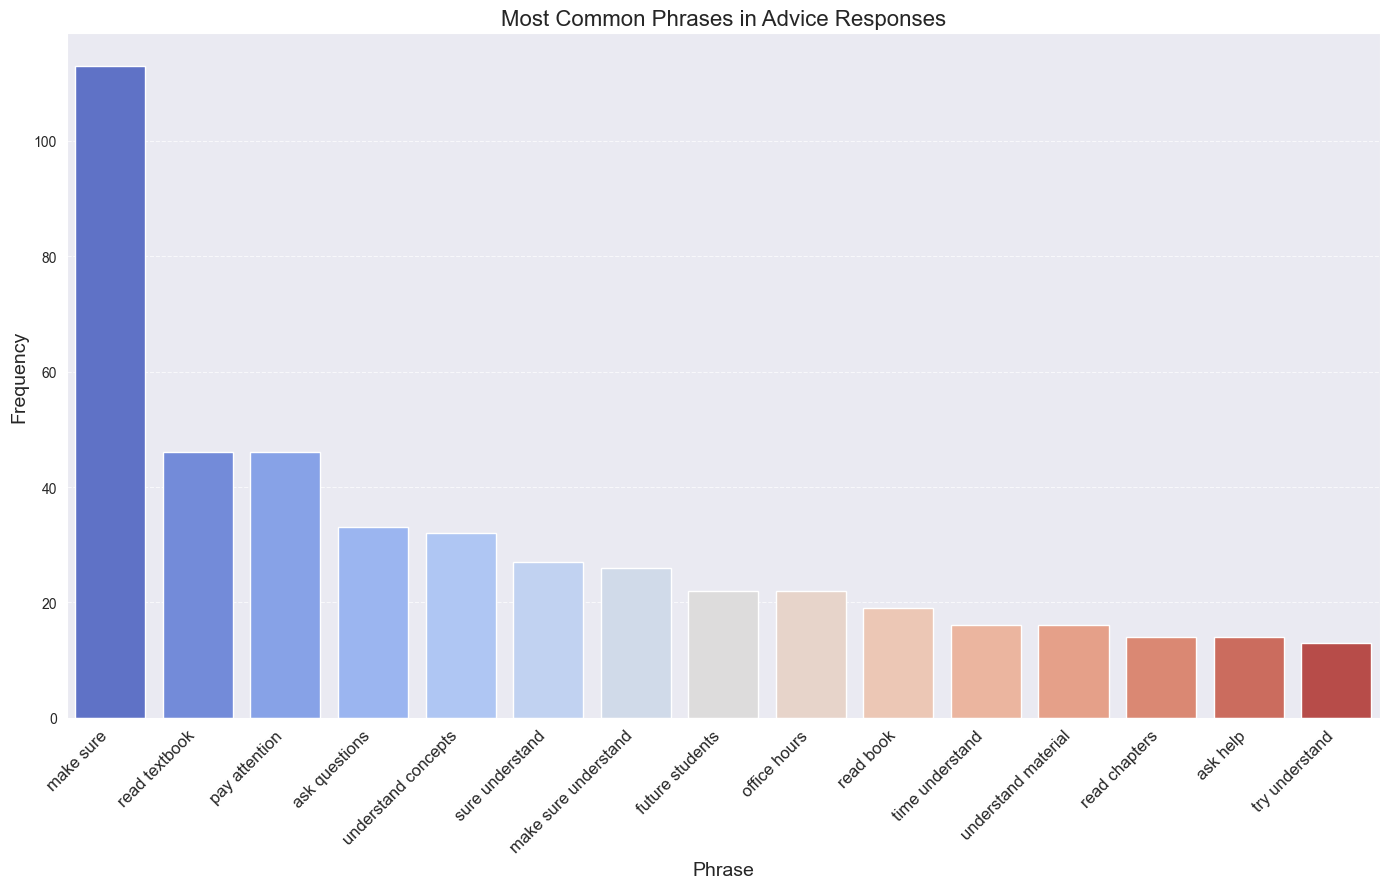

In [277]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))

# Custom color palette
colors = sns.color_palette("coolwarm", len(top_advice_ngrams))

# Creating the bar plot
sns.barplot(x=[word[0] for word in top_advice_ngrams], y=[word[1] for word in top_advice_ngrams], palette=colors)

# Title and labels
plt.title('Most Common Phrases in Advice Responses', fontsize=16)
plt.xlabel('Phrase', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)



plt.tight_layout()
plt.show()


/var/folders/zv/b1gy51ms7yv5bf2qm_gz0_fw0000gn/T/ipykernel_40746/2110582409.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[word[0] for word in top_advice_ngrams], x=[word[1] for word in top_advice_ngrams], palette=colors)


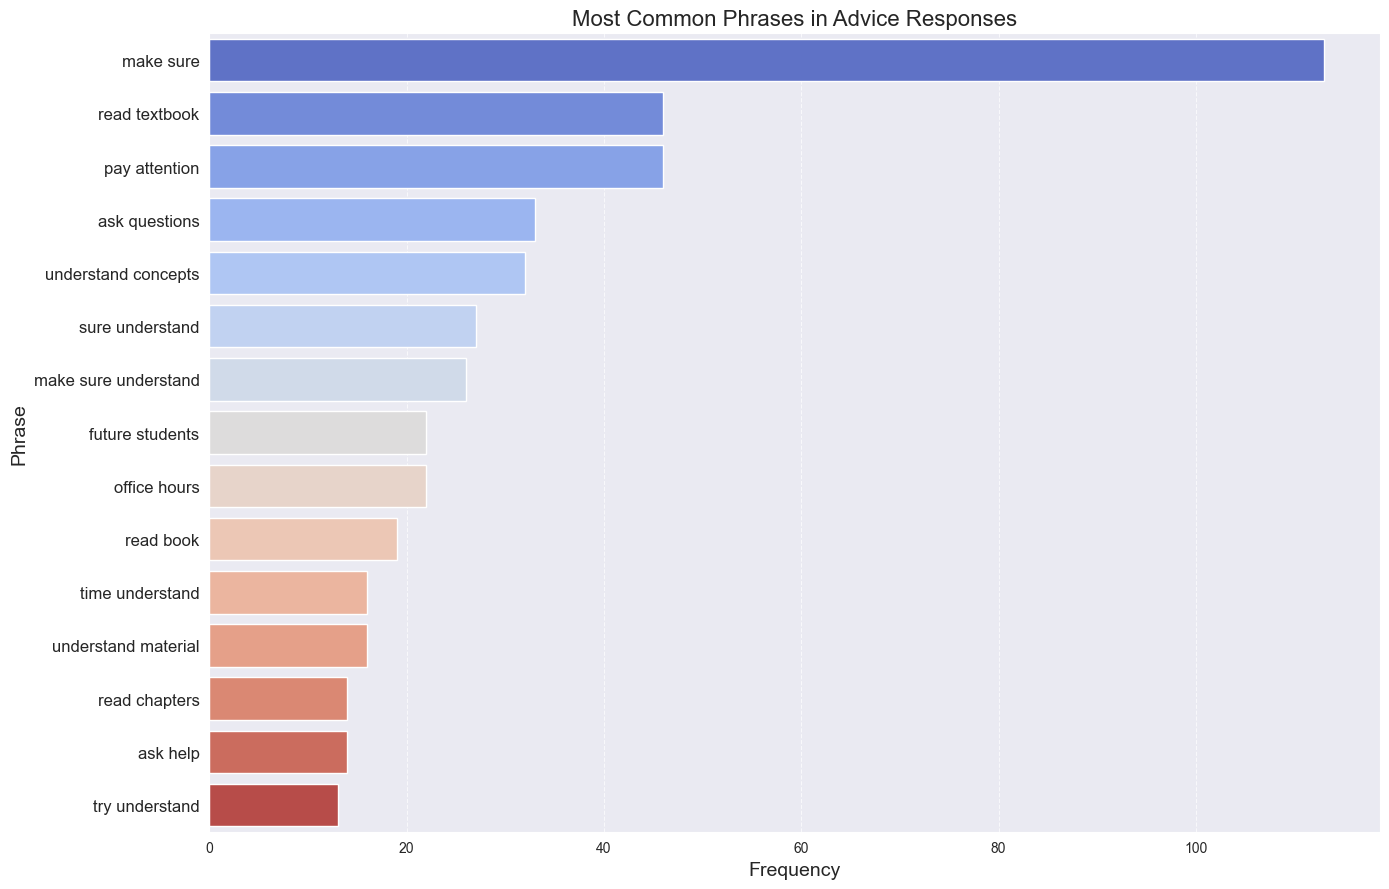

In [278]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))

# Custom color palette
colors = sns.color_palette("coolwarm", len(top_advice_ngrams))

# Creating the horizontal bar plot
sns.barplot(y=[word[0] for word in top_advice_ngrams], x=[word[1] for word in top_advice_ngrams], palette=colors)

# Title and labels
plt.title('Most Common Phrases in Advice Responses', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Phrase', fontsize=14)

# Rotating y-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)

# Adding grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


/var/folders/zv/b1gy51ms7yv5bf2qm_gz0_fw0000gn/T/ipykernel_40746/2800078854.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[0] for word in top_challenges_ngrams], y=[word[1] for word in top_challenges_ngrams], palette=colors)


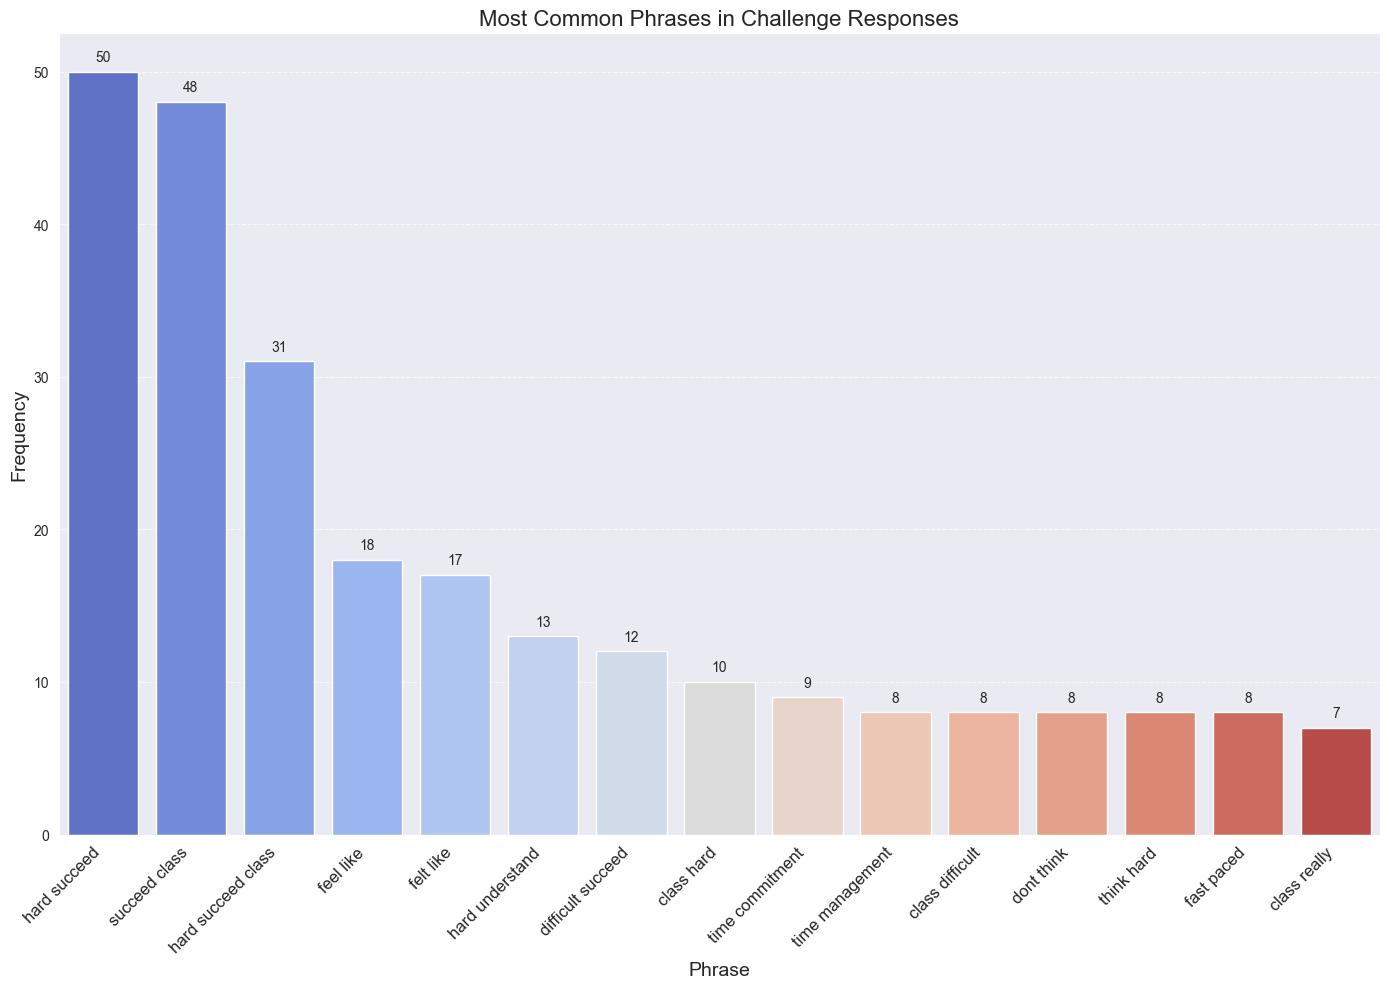

In [279]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Custom color palette
colors = sns.color_palette("coolwarm", len(top_challenges_ngrams))

# Creating the bar plot
sns.barplot(x=[word[0] for word in top_challenges_ngrams], y=[word[1] for word in top_challenges_ngrams], palette=colors)

# Title and labels
plt.title('Most Common Phrases in Challenge Responses', fontsize=16)
plt.xlabel('Phrase', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels
for i, freq in enumerate([word[1] for word in top_challenges_ngrams]):
    plt.text(i, freq + 0.5, str(freq), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

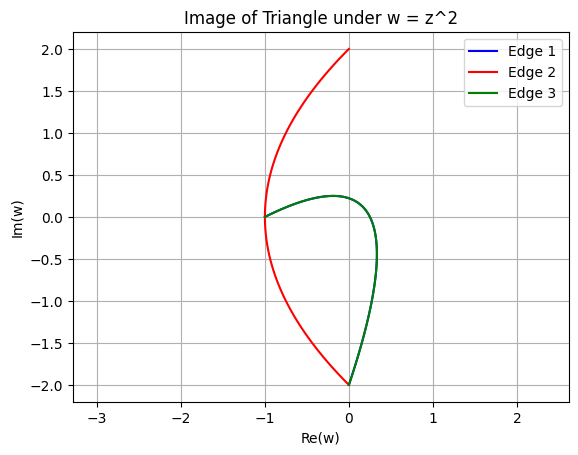

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parametric equations for each edge of the triangle after applying w = z^2
def edge1(t):
    z = (1 - t) * 1j + t * (1 - 1j)
    return z**2

def edge2(t):
    z = (1 - t) * (1 - 1j) + t * (-1 - 1j)
    return z**2

# Third edge is the reverse of the first edge
def edge3(t):
    return edge1(1-t)  # Reversing parameter values

# Parametric range
t_values = np.linspace(0, 1, 100)

# Calculate the points on each edge
edge1_points = [edge1(t) for t in t_values]
edge2_points = [edge2(t) for t in t_values]
edge3_points = [edge3(t) for t in t_values]

# Extract real and imaginary parts for plotting
edge1_real = [point.real for point in edge1_points]
edge1_imag = [point.imag for point in edge1_points]

edge2_real = [point.real for point in edge2_points]
edge2_imag = [point.imag for point in edge2_points]

edge3_real = [point.real for point in edge3_points]
edge3_imag = [point.imag for point in edge3_points]

# Plot the image of the triangle under w = z^2
plt.plot(edge1_real, edge1_imag, label='Edge 1', color='blue')
plt.plot(edge2_real, edge2_imag, label='Edge 2', color='red')
plt.plot(edge3_real, edge3_imag, label='Edge 3', color='green')

plt.xlabel('Re(w)')
plt.ylabel('Im(w)')
plt.title('Image of Triangle under w = z^2')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio
plt.show()
